In [526]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [527]:
df = pd.read_csv("pokemon_data.csv", index_col = "Name")


In [528]:
df['Smash Scaled'] = (df['Smashes'] - df['Smashes'].min()) / (df['Smashes'].max() - df['Smashes'].min())
df['Pass Scaled'] = (df['Passes'] - df['Passes'].min()) / (df['Passes'].max() - df['Passes'].min())


# Ensure Total = 1 for each row
df['Total'] = df['Smash Scaled'] + df['Pass Scaled']
df['Pass Normalized'] = df['Pass Scaled'] / df['Total']
df['Smash Normalized'] = df['Smash Scaled'] / df['Total']

df['filename'] = df.index + '.png'  # Example: Pikachu -> Pikachu.jpg
df['Smash Normalized'] = df['Smash Normalized'] *10

In [529]:
df.head()

,Passes,Smashes,Smash Scaled,Pass Scaled,Total,Pass Normalized,Smash Normalized,filename
Name,,,,,,,,
Bulbasaur,1187934,331851,0.408613,1.000000,1.408613,0.709918,2.900818,Bulbasaur.png
Ivysaur,1172763,303853,0.373735,0.987044,1.360779,0.725352,2.746478,Ivysaur.png
Venusaur,1175757,273495,0.335917,0.989601,1.325518,0.746577,2.534232,Venusaur.png
Charmander,1152826,271930,0.333967,0.970017,1.303985,0.743887,2.561130,Charmander.png
Charmeleon,1135715,275524,0.338445,0.955404,1.293849,0.738420,2.615797,Charmeleon.png


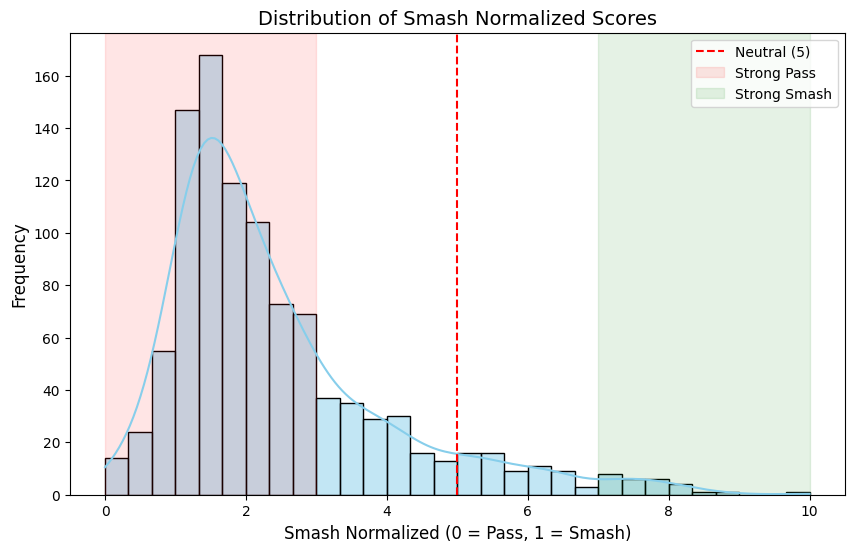

In [530]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.histplot(df['Smash Normalized'], kde=True, bins=30, color='skyblue', edgecolor='black')

# Highlight key regions
ax.axvline(5, color='red', linestyle='--', label='Neutral (5)')
ax.axvspan(0, 3, color='red', alpha=0.1, label='Strong Pass')
ax.axvspan(7, 10, color='green', alpha=0.1, label='Strong Smash')

plt.title("Distribution of Smash Normalized Scores", fontsize=14)
plt.xlabel("Smash Normalized (0 = Pass, 1 = Smash)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

## Dataset and Preprocessing

In [531]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd

class SmashDataset(Dataset):
    def __init__(self, image_dir, paths, labels, augment_flags):
        self.image_dir = image_dir
        self.paths = paths
        self.labels = labels  # Correctly store the labels
        self.augment_flags = augment_flags  # Store augment flags in the correct variable
        
        self.basic_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def remove_alpha(self, image):
        if image.mode == 'RGBA':
            background = Image.new("RGB", image.size, (255, 255, 255))
            background.paste(image, mask=image.split()[3])  # 3 is alpha channel
            return background
        else:
            return image.convert("RGB")

    def __getitem__(self, idx):
        path = os.path.join(self.image_dir, self.paths[idx])
        image = Image.open(path)
        image = self.remove_alpha(image)

        label = self.labels[idx].astype(np.float32)
        
        # Use augment_flags to determine if augmentation is needed
        if self.augment_flags[idx]:
            image = self.augment_transform(image)
        else:
            image = self.basic_transform(image)

        return image, label

    def __len__(self):
        return len(self.paths)



# Oversampling

In [532]:
# Step 1: Label buckets (before split)
from sklearn.model_selection import train_test_split


low_mask = df['Smash Normalized'] <= 4.0
mid_mask = (df['Smash Normalized'] > 4.0) & (df['Smash Normalized'] <= 7.0)
high_mask = df['Smash Normalized'] > 7.0

df['bucket'] = np.select([low_mask, mid_mask, high_mask], ['low', 'mid', 'high'])
df['augment_flags'] = False  # default to False

# Step 2: Split before oversampling
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['bucket'])

# Step 3: Apply oversampling only on training data
low_df = train_df[train_df['bucket'] == 'low']
mid_df = train_df[train_df['bucket'] == 'mid']
high_df = train_df[train_df['bucket'] == 'high']

target_count = max(len(low_df), len(mid_df))

oversampled_mid = mid_df.sample(n=target_count, replace=True, random_state=42)
oversampled_high = high_df.sample(n=target_count, replace=True, random_state=42)

oversampled_mid['augment_flags'] = True
oversampled_high['augment_flags'] = True
low_df['augment_flags'] = False

resampled_train_df = pd.concat([low_df, mid_df, oversampled_high])
resampled_train_df = resampled_train_df.sample(frac=1.0, random_state=42)

# Step 4: Set up datasets
train_dataset = SmashDataset(
    "images",
    resampled_train_df['filename'].values,
    resampled_train_df['Smash Normalized'].values.astype(np.float32),
    resampled_train_df['augment_flags'].values
)

val_dataset = SmashDataset(
    "images",
    val_df['filename'].values,
    val_df['Smash Normalized'].values.astype(np.float32),
    val_df['augment_flags'].values  # All False unless you want otherwise
)

# Step 5: DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)


C:\Users\user\AppData\Local\Temp\ipykernel_22688\360659268.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df['augment_flags'] = False


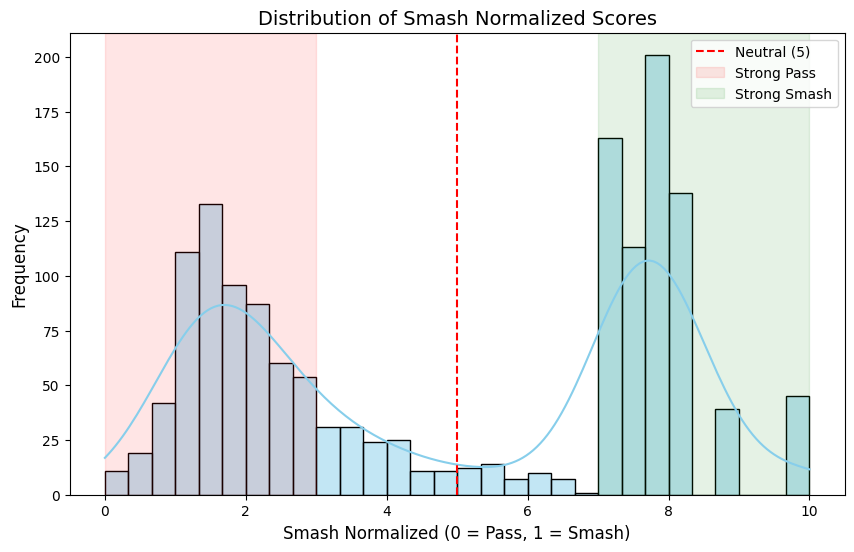

In [533]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(resampled_train_df['Smash Normalized'], kde=True, bins=30, color='skyblue', edgecolor='black')

# Highlight key regions
ax.axvline(5, color='red', linestyle='--', label='Neutral (5)')
ax.axvspan(0, 3, color='red', alpha=0.1, label='Strong Pass')
ax.axvspan(7, 10, color='green', alpha=0.1, label='Strong Smash')

plt.title("Distribution of Smash Normalized Scores", fontsize=14)
plt.xlabel("Smash Normalized (0 = Pass, 1 = Smash)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

# Training

## Model

In [534]:
import torch.nn as nn

class SmashRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.mobilenet_v2(pretrained=True)
        self.feature_extractor = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = True
        
        self.regressor = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1280, 512),
        
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 256),
        
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 64),
        
        nn.ReLU(),
        nn.Linear(64, 1)
)


    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.pool(x)
        x = self.regressor(x)
        return x.squeeze(1)


## Training Setup

In [535]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmashRegressor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)




def weighted_huber_loss(y_pred, y_true, delta=2.0):
    error = y_true - y_pred
    weights = 1.0 + 0.5 * y_true
    abs_error = torch.abs(error)
    condition = abs_error < delta
    loss = torch.where(condition, 0.5 * error ** 2, delta * (abs_error - 0.5 * delta))
    return torch.mean(weights * loss)

def custom_accuracy(y_pred, y_true):
    return ((torch.abs(y_pred - y_true) < 0.5).float().mean()).item()


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Training Loop

In [ ]:
from tqdm import tqdm

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []


best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(25):
    model.train()
    train_losses, train_accs = [], []

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = weighted_huber_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(custom_accuracy(outputs, labels))

    model.eval()
    val_losses, val_accs = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            val_losses.append(weighted_huber_loss(outputs, labels).item())
            val_accs.append(custom_accuracy(outputs, labels))

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    train_acc = np.mean(train_accs)
    val_acc = np.mean(val_accs)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    scheduler.step()


  4%|▍         | 1/24 [00:00<00:19,  1.20it/s]

## Plotting

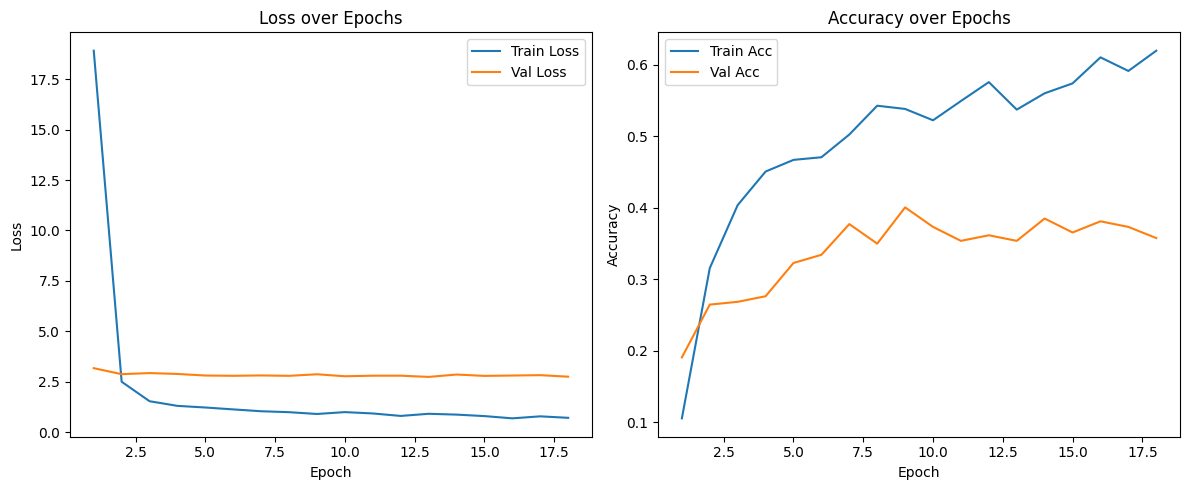

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, label='Train Acc')
plt.plot(epochs, val_acc_history, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image
from torchvision import transforms

# Same preprocessing as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0, 1]
])

def predict_image(path):
    image = Image.open(path).convert('RGBA')
    
    # If image has alpha channel, blend it with white
    if image.mode == 'RGBA':
        background = Image.new("RGB", image.size, (255, 255, 255))
        background.paste(image, mask=image.split()[3])  # Alpha channel
        image = background
    else:
        image = image.convert("RGB")

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim
    
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model = model.to(device)
    model.eval()
    
    with torch.no_grad():
        prediction = model(image_tensor)
        return prediction.item()

In [ ]:
score = predict_image("leaf.jpg")
print(f"Smash score (0–10 scale): {score:.2f}")
# print(resampled_df.loc["Greninja"]['Smash Normalized'])


UnboundLocalError: cannot access local variable 'model' where it is not associated with a value